In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, GroupedLayerControl
import ast
import seaborn as sns
from scipy.optimize import curve_fit

from data_utilities import *

## Regression

In [2]:
def make_df(services_filter: list = []):

    data = pd.DataFrame()
    if len(services_filter) != 0:
        for i in range(len(services_filter)):
            if type(services_filter[i]) != str:
                services_filter[i] = services[services_filter[i]]
        for i in services_filter:
            # data = DF[DF["Service Area and Request"].isin(services_filter)]
            data = DF[DF["Service Request"].isin(services_filter)]
    else:
        data = DF

    census_df = pd.read_csv("./assets/census_2016_new.csv")
    census_df = census_df[census_df["Boundary Type"] == "Neighbourhood"]

    # combined_df = pd.merge(DF, census_df, left_on="Neighbourhood", right_on="Boundary Name", how="inner")
    combined_df = data.groupby("Neighbourhood").size().sort_values().to_frame().rename(columns={0: "Count"})
    combined_df = pd.merge(combined_df, census_df, left_on="Neighbourhood", right_on="Boundary Name", how="inner")

    return combined_df[combined_df['Population 2016'] != 0]

combined_df = make_df()

In [3]:
def plot_regression(x:str, y:str, data, xlables:str="", ylables:str="", xunit:str="", yunit:str="", xpercent:bool=False, ypercent:bool=False) -> tuple[float, float, float]:
    if xpercent:
        data[x] *= 100
        xunit = "Percent"
    if ypercent:
        data[y] *= 100
        yunit = "Percent"
    ci = sns.lmplot(x=x, y=y, data=data)
    if xlables == "":
        xlables = x
    if ylables == "":
        ylables = y
    if xunit != "":
        xunit = " (" + xunit + ")"
    if yunit != "":
        yunit = " (" + yunit + ")"
    ci.set(xlabel=xlables + xunit)
    ci.set(ylabel=ylables + yunit)
    plt.show()
    slope, intercept = np.polyfit(data[x], data[y], 1)
    conf_int = float(np.mean(np.array(ci.ax.lines[0].get_ydata())))
    if xpercent:
        data[x] /= 100
    if ypercent:
        data[y] /= 100
    return slope, intercept, conf_int


### Household income

In [4]:
combined_df['Average Household Income'] = combined_df['Average and Median Household Income'].str.strip("[]").str.split(', ').str[0]
combined_df['Median Household Income'] = combined_df['Average and Median Household Income'].str.strip("[]").str.split(', ').str[1]
combined_df['Average Household Income']= combined_df['Average Household Income'].astype(int)
combined_df['Median Household Income']= combined_df['Median Household Income'].astype(int)

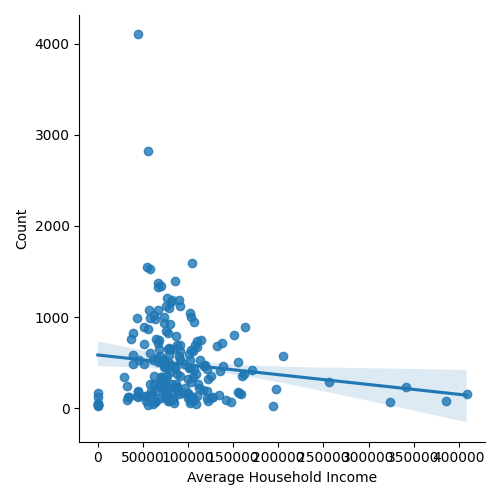

In [5]:
# combined_df.plot(kind="scatter", x="Average Household Income", y="Count")
sns.lmplot(x="Average Household Income", y="Count", data=combined_df)
plt.show()

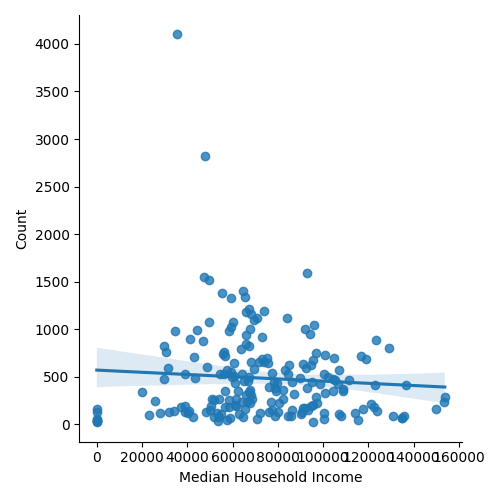

In [6]:
# combined_df.plot(kind="scatter", x="Median Household Income", y="Count")
sns.lmplot(x="Median Household Income", y="Count", data=combined_df)
plt.show()

Income doesn't seem to be a good predictor of the number of events.

### Population Density

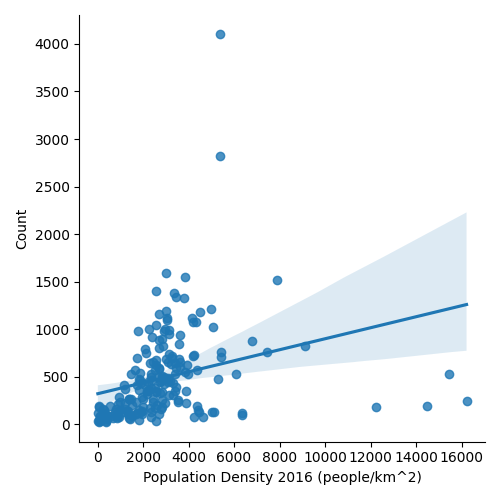

((0.05783960349326034, 321.3150257456834, 790.8127179806423),)

In [7]:
(
    plot_regression("Population Density 2016", "Count", combined_df, xunit="people/km^2"),
    # plot_regression("Population Density 2016", "Count", combined_df[combined_df["Population Density 2016"] < 6000], xunit="people/km^2")
)

In [8]:
combined_df[combined_df["Population Density 2016"]>12000][combined_df["Count"]<600]

C:\Users\tommy\AppData\Local\Temp\ipykernel_13688\1061953178.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined_df[combined_df["Population Density 2016"]>12000][combined_df["Count"]<600]


,Count,Boundary Type,Boundary Name,Population 2016,Population Density 2016,Year opened,Aboriginal,Aboriginal Percent,Visible Minorities Numbers,Visible Minorities Percent,...,Own vs Rent Percent,Bad Dwelling,Bad Dwelling Percent,Average and Median Household Income,Commuting Method,Commuting Method Percent,LIM-AT,LICO-AT,Average Household Income,Median Household Income
98,182,Neighbourhood,Alpine Place,3895,12236.883443,1971,475,0.121951,"[145, 260, 630, 15, 0, 35, 35, 15, 10, 0, 10, 50]","[0.12033195020746888, 0.2157676348547718, 0.52...",...,"[0.03991130820399113, 0.9600886917960089]",160,0.070953,"[44114, 37015]","[855, 575]","[0.5979020979020979, 0.40209790209790214]",0.311938,0.243902,44114,37015
102,188,Neighbourhood,Roslyn,4550,14491.045808,1971,235,0.051648,"[50, 135, 90, 90, 30, 85, 10, 40, 30, 0, 10, 15]","[0.08547008547008547, 0.23076923076923078, 0.1...",...,"[0.3697068403908795, 0.6302931596091205]",225,0.073290,"[88912, 61605]","[1415, 990]","[0.5883575883575883, 0.41164241164241167]",0.135165,0.119780,88912,61605
115,240,Neighbourhood,Central Park,3775,16221.907095,2001,675,0.178808,"[850, 185, 1065, 115, 105, 35, 10, 10, 30, 10,...","[0.34, 0.074, 0.426, 0.046, 0.042, 0.014, 0.00...",...,"[0.11023622047244094, 0.889763779527559]",190,0.099738,"[32248, 25574]","[435, 930]","[0.31868131868131866, 0.6813186813186812]",0.543046,0.475497,32248,25574
164,524,Neighbourhood,Broadway-Assiniboine,5270,15452.189109,1981,720,0.136622,"[340, 205, 505, 160, 25, 185, 45, 30, 55, 10, ...","[0.2118380062305296, 0.1277258566978193, 0.314...",...,"[0.06721536351165981, 0.9327846364883402]",345,0.094521,"[45656, 38847]","[930, 2135]","[0.3034257748776509, 0.6965742251223491]",0.313390,0.275404,45656,38847


There's a positive correlation between population density and number of events.

There are some outliers. Notice these neighbourhoods have a high population density but low number of events because these neighbourhoods have a lot of apartment buildings instead of houses. These apartment buildings have their own caretaking service, which overlaps with city's service and is not included in the data.

### Unemployment Rate and education

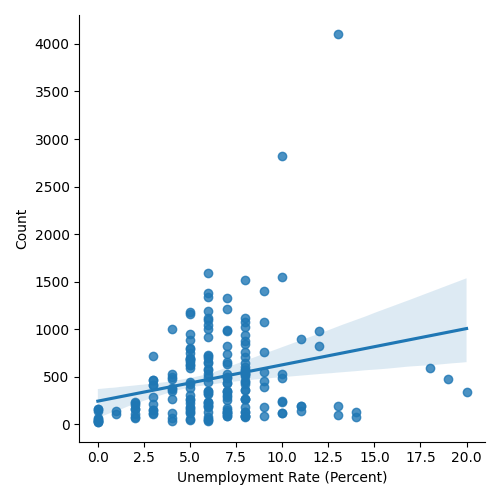

(38.165016407918124, 243.77079777854084, 625.4209618577227)

In [9]:
plot_regression(x="Unemployment Rate", y="Count", data=combined_df, xunit="Percent", xpercent=True)

There's a positive correlation between the unemployment rate and the number of events.

For neighbourhoods with unemployment rate > 10%, the education level is much lower. For example, both China Town and Lord Selkirk Park have more than half of people doesn't have a high school diploma or other higher education.

In [35]:
combined_df['No Education'] = combined_df['Education Numbers'].str.strip("[]").str.split(', ').str[0]
combined_df['High School Education'] = combined_df['Education Numbers'].str.strip("[]").str.split(', ').str[1]
combined_df['Undergraduate Education'] = combined_df['Education Numbers'].str.strip("[]").str.split(', ').str[2]

combined_df['No Education'] = combined_df['No Education'].astype(int)
combined_df['High School Education'] = combined_df['High School Education'].astype(int)
combined_df['Undergraduate Education'] = combined_df['Undergraduate Education'].astype(int)

combined_df['No Education Rate'] = combined_df['No Education'] / combined_df['Population 2016']
combined_df['High School Education Rate'] = combined_df['High School Education'] / combined_df['Population 2016']
combined_df['Undergraduate Education Rate'] = combined_df['Undergraduate Education'] / combined_df['Population 2016']

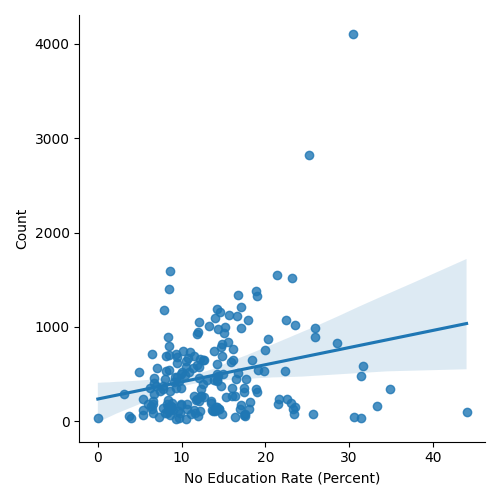

(18.15715460623106, 236.5961500959107, 636.4858646379033)

In [36]:
plot_regression(x="No Education Rate", y="Count", data=combined_df, xpercent=True)

This confirms what we had before, poor education have a positive correlation with the number of events.

### Infrastructure and Dwelling Conditions

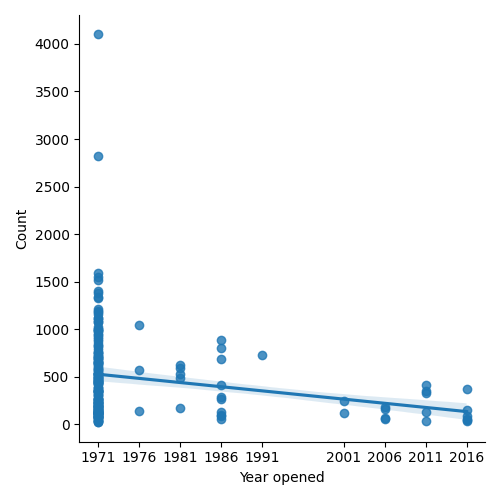

In [11]:
sns.lmplot(x="Year opened", y="Count", data=combined_df).ax.set_xticks([1971, 1976, 1981, 1986, 1991, 2001, 2006, 2011, 2016])
plt.show()

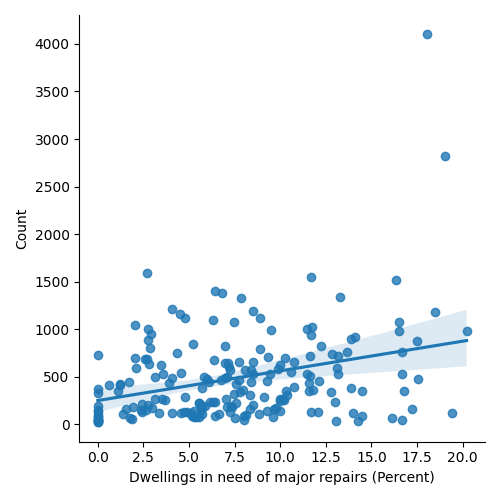

(31.183543255357684, 250.2520954489658, 565.4955655167889)

In [12]:
# combined_df.plot(kind="scatter", x="Bad Dwelling Percent", y="Count")
plot_regression(x="Bad Dwelling Percent", y="Count", data=combined_df, xlables="Dwellings in need of major repairs", xpercent=True)

### Ethnicity

There is a positive correlation between the proportion of bad dwelling and the number of events.

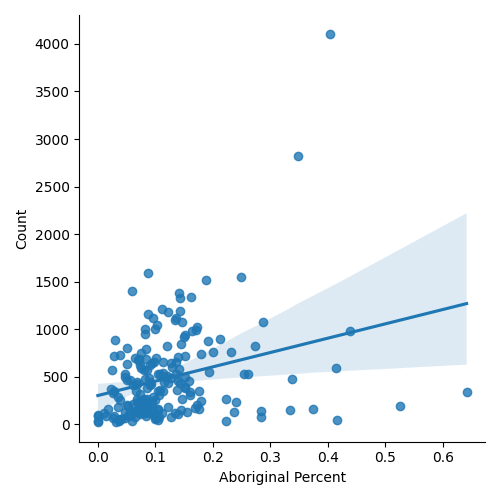

In [37]:
# combined_df.plot(kind="scatter", x="Aboriginal Percent", y="Count")
sns.lmplot(x="Aboriginal Percent", y="Count", data=combined_df)
plt.show()

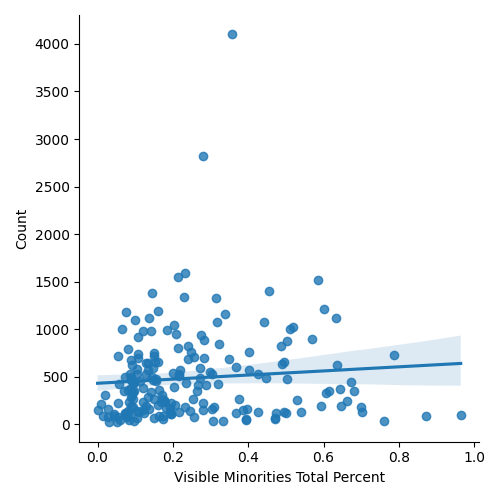

In [38]:
# combined_df.plot(kind="scatter", x="Visible Minorities Total Percent", y="Count")
sns.lmplot(x="Visible Minorities Total Percent", y="Count", data=combined_df)
plt.show()

### Immigration Status

In [39]:
combined_df['Non Citizenship Percent'] = combined_df['Citizenship Percent'].str.strip("[]").str.split(', ').str[1].astype(float)

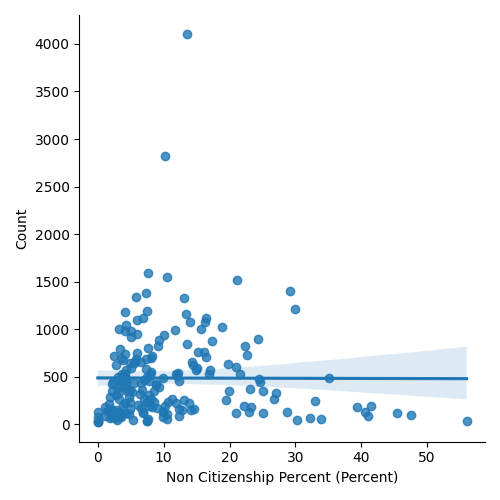

(-0.13602486707658235, 487.85122612881236, 484.042529850668)

In [56]:
# combined_df.plot(kind="scatter", x="Non Citizenship Percent", y="Count")
plot_regression(x="Non Citizenship Percent", y="Count", data=combined_df,xpercent=True)

### Infrastructure and Dwelling Conditions

In [41]:
combined_df['House'] = combined_df['Household Type'].str.strip("[]").str.split(', ').str[0].astype(int)
combined_df['Apartment'] = combined_df['Household Type'].str.strip("[]").str.split(', ').str[1].astype(int)
combined_df['Other'] = combined_df['Household Type'].str.strip("[]").str.split(', ').str[2].astype(int)

In [42]:
combined_df['Household sum']  = combined_df['Household Type'].str.strip("[]").str.split(', ').str[0].astype(int)
combined_df['Household sum'] += combined_df['Household Type'].str.strip("[]").str.split(', ').str[1].astype(int)
combined_df['Household sum'] += combined_df['Household Type'].str.strip("[]").str.split(', ').str[2].astype(int)
combined_df['House Ratio'] = combined_df['House']/combined_df['Household sum']
combined_df['Apartment Ratio'] = combined_df['Apartment']/combined_df['Household sum']

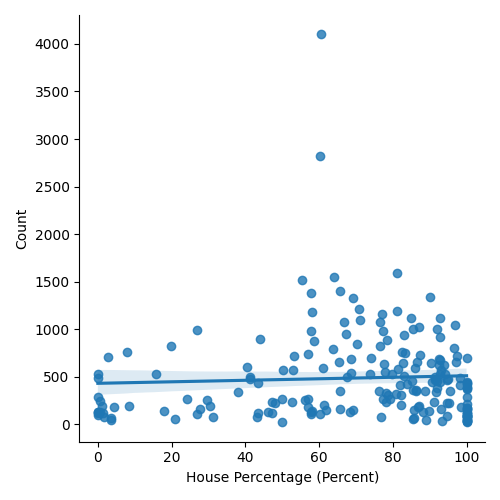

(0.794505212447362, 431.2314301800046, 470.95669080237263)

In [43]:
plot_regression(x='House Ratio', y="Count", data=combined_df, xlables="House Percentage", xpercent=True)

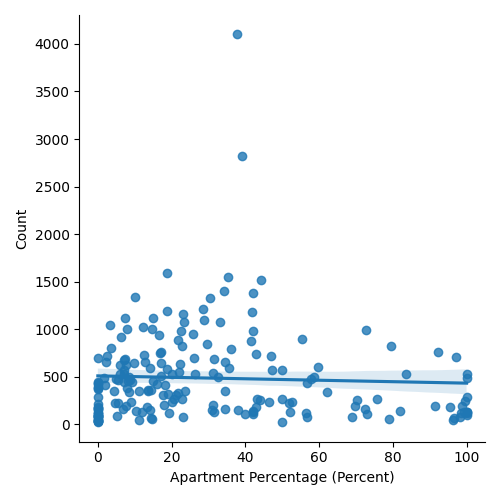

(-0.7636342544947983, 509.41760645386637, 471.23589372912653)

In [44]:
plot_regression(x="Apartment Ratio", y="Count", data=combined_df, xlables="Apartment Percentage", xpercent=True)

In [45]:
combined_df['Rent Percent'] = combined_df['Own vs Rent Percent'].str.strip("[]").str.split(', ').str[1].astype(float)

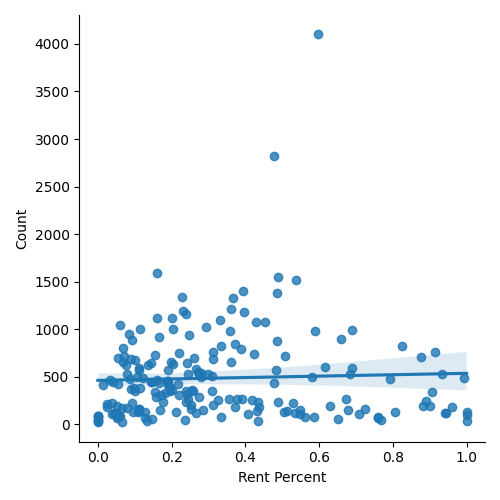

In [46]:
# combined_df.plot(kind="scatter", x="Rent Percent", y="Count")
sns.lmplot(x="Rent Percent", y="Count", data=combined_df)
plt.show()

### Means of Commuting

In [47]:
combined_df['Private Commuting Percent'] = combined_df['Commuting Method Percent'].str.strip("[]").str.split(', ').str[0].astype(float)
combined_df['Public Commuting Percent'] = combined_df['Commuting Method Percent'].str.strip("[]").str.split(', ').str[1].astype(float)

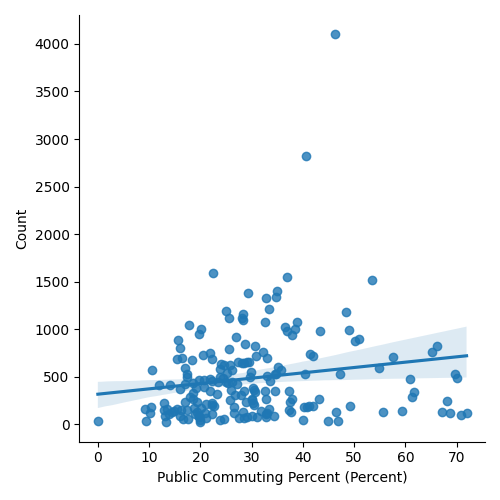

(5.611662096224153, 316.7816279638192, 518.6645936206635)

In [60]:
plot_regression(x="Public Commuting Percent", y="Count", data=combined_df, xpercent=True)

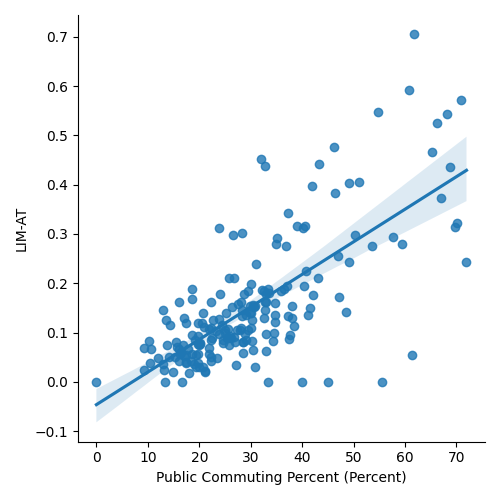

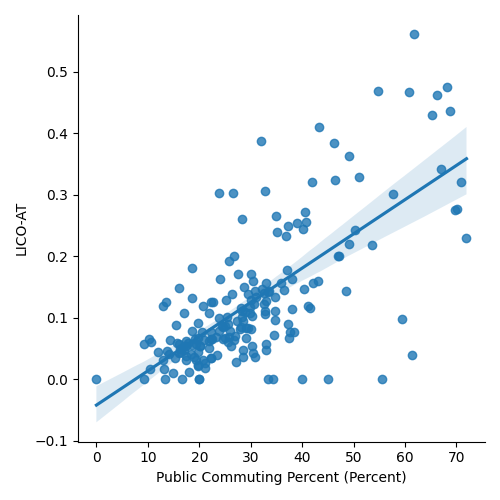

((0.006609238788379125, -0.04640259088588368, 0.19136880454970687),
 (0.005567058721096087, -0.04197988780609934, 0.1582984442333331))

In [59]:
(
    plot_regression(x="Public Commuting Percent", y="LIM-AT", data=combined_df, xpercent=True),
    plot_regression(x="Public Commuting Percent", y="LICO-AT", data=combined_df, xpercent=True)
)

### Poverty and income

In [50]:
high_poverty_low_reports = combined_df[combined_df["LIM-AT"] > 0.2][combined_df["Count"] < 100]

C:\Users\tommy\AppData\Local\Temp\ipykernel_13688\868849869.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_poverty_low_reports = combined_df[combined_df["LIM-AT"] > 0.2][combined_df["Count"] < 100]


c:\Users\tommy\GitHub\winnipeg-311-data-analysis\venv\Lib\site-packages\seaborn\axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


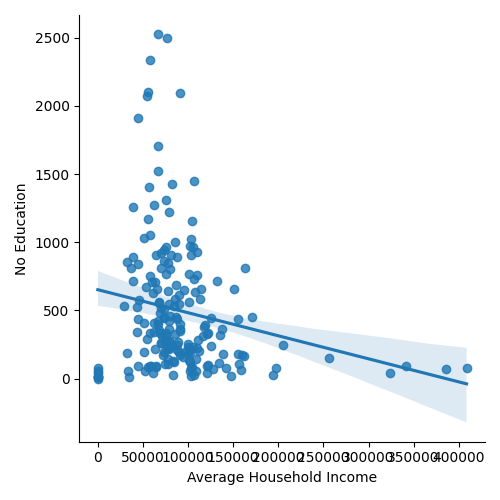

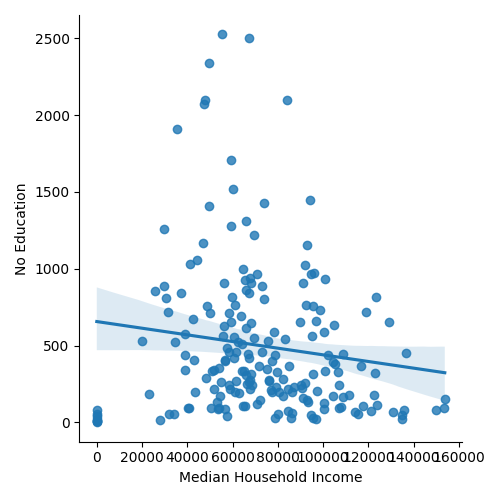

In [51]:
sns.lmplot(x="Average Household Income", y="No Education", data=combined_df)
plt.show()
sns.lmplot(x="Median Household Income", y="No Education", data=combined_df)
plt.show()

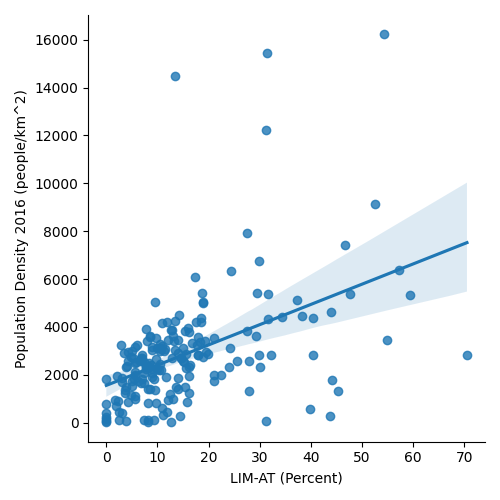

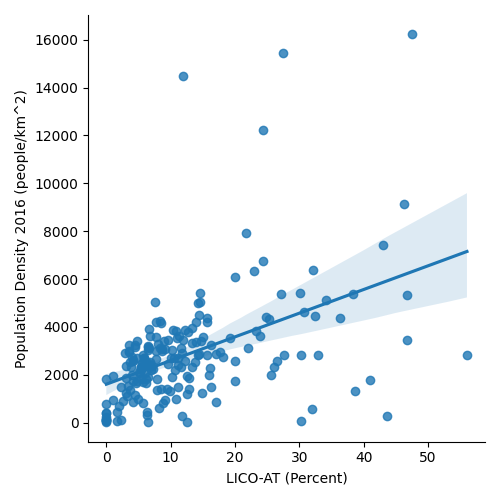

((84.61824361240832, 1555.9321514500805, 4538.378442707094),
 (98.93609482694235, 1604.233434623326, 4377.6878961654775))

In [52]:
(plot_regression(x="LIM-AT", y="Population Density 2016", data=combined_df, xpercent=True, yunit="people/km^2"), 
plot_regression(x="LICO-AT", y="Population Density 2016", data=combined_df, xpercent=True, yunit="people/km^2"))

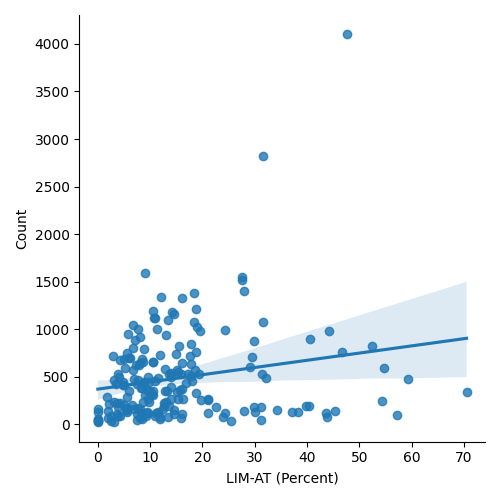

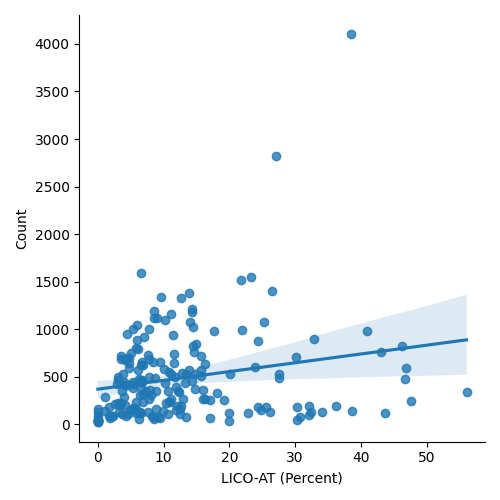

((7.578618068910166, 370.1608322768499, 637.2760592958144),
 (9.250543263381019, 369.5692660555652, 628.8877739306722))

In [53]:
(plot_regression(x="LIM-AT", y="Count", data=combined_df, xpercent=True),
plot_regression(x="LICO-AT", y="Count", data=combined_df, xpercent=True))

### service specific

TODO: Find which service request is more likely to be reported in high poverty areas?

TODO: find regression with every category of service

In [54]:
#            graffiti, garbage,   insect,  Dog,  water,    snow
# for srv in [[4],      [5, 6, 7], [8, 16], [1],  [12, 17], [2, 10, 11, 14, 15], [9]]:
    # combined_df = make_df(srv)
    # sns.lmplot(x="LIM-AT", y="Count", data=combined_df)
    # plt.show()
    # sns.lmplot(x="LICO-AT", y="Count", data=combined_df)
    # plt.show()